Starting points in columns: [[2.0, 2.0], [0.01, 0.01], [0.01, 0.01], [0.01, 0.01], [0.01, 0.01], [0.01, 0.01], [0.01, 0.01], [0.01, 0.01], [0.01, 0.01], [0.01, 0.01]]
Initial weights:  [0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091]
(600, 600)


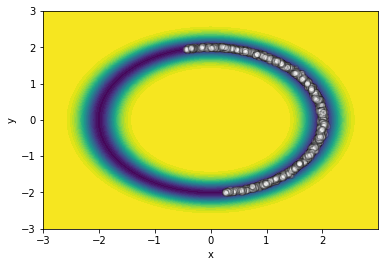

In [2]:
import TSLCSim as rl
import numpy as np 
import importlib
importlib.reload(rl)
import matplotlib.pyplot as plt

#the dimension of the state(could be lower or higher than the number of OPs)
D = 10
#D = 5
Xtemp = [[.01,.01] for i in range(D-2)]
X = [[2.,2.],[0.01,0.01]]

#d is the known dimension of the submanifold of the potential basically
#in the circle case this is 1. This is used in how many principal components we use when updating the weights
d=1

#the intial starting points, each column is a starting state
X = X + Xtemp
print('Starting points in columns:',X)

N = len(X[0]) # number of parallel runs 


#list of order parameters(OPs). x and y(and all D coordinate projections) are automatically included, no need to specify them.
#if you want to try other CVs(synonym of OP), you can make the fun_list longer, as long as you also make grad_fun_list longer
#this is the angle function. You have to define it piecewise because of teh definition of arctan
fun_list = [ lambda x: np.arctan(x[1]/x[0]) if x[0]>0 else (np.arctan(x[1]/x[0]) - np.pi) if (x[0]<0 and x[1] < 0) else (np.arctan(x[1]/x[0]) + np.pi)]

#grad_fun_list is right now just the gradient of the angle, which I computed by hand since that's not hard
#(partial derivatives of arctan(y/x))


temp = [lambda x : -x[1]/(x[0]**2 + x[1]**2), lambda x : x[0]/(x[0]**2 + x[1]**2)]
temp1 = [lambda x: 0 for i in range(D-2)]
gradtheta = temp + temp1
grad_fun_list = [gradtheta]
n_OP = D + len(fun_list)

# run first round of simulation
my_sim = rl.mockSimulation(len(X),d,fun_list,grad_fun_list)
W_0 = [1/n_OP for i in range(n_OP)] #no direction, initial guess of weights
print('Initial weights: ',W_0)
Ws = [] # series of weights, will be used to graph weights as a function of iteration


# first round
trj1 = my_sim.run_noPlt(X, nstepmax = 25)
trj1 = my_sim.PreAll(trj1)

trjs = trj1
#don't specify n_cl in the call below unless you want it to override the n_cl which is computed
#trj1_Sp 
trj1_Sp,cl_trjs,cl_centroids,cl_counts = my_sim.PreSamp(trj1, starting_n = N) # pre analysis
trj1_Sp_theta = my_sim.map(trj1_Sp)
newPoints = my_sim.findStarting(trj1_Sp_theta, trj1_Sp, W_0, starting_n = N )

trjs_theta = trj1_Sp_theta

trjs_Sp_theta = trj1_Sp_theta
for round in range(400):
    #sampling dfq from newPoints
    trj1 = my_sim.run_noPlt(newPoints, nstepmax = 5)
    trj1 = my_sim.PreAll(trj1)
    
    #full trajectory so far
    com_trjs = []

    for theta in range(len(trj1)):
        com_trjs.append(np.concatenate((trjs[theta], trj1[theta])))
    
    #observations are in columns
    trjs = np.array(com_trjs)
    
    #the values of the CVs on the trajectory
    trjs_theta = np.array(my_sim.map(trjs))
    
    #updates the std and mean
    #note that the standard deviation and mean are stored in the my_sim mockSimulation object while we're keeping
    #track of the full trajectories so far in trjs and trjs_theta
    my_sim.updateStat(trjs_theta)
    
    
    #find states in least count clusters, and also which clusters points belonged to
    #don't specify n_cl in the call below unless you want it to override the n_cl which is computed
    trjs_Sp,cl_trjs,cl_centroids,cl_counts = my_sim.PreSamp(trjs, starting_n = N)
    
    #this should be a numpy array with K rows, the ith row is an array 
    #of theta_i evaluated at each data point in trjs_Sp
    trjs_Sp_theta = np.array(my_sim.map(trjs_Sp))
    #print(trjs_Sp_theta)
    
    
    W_1 = my_sim.updateW(trjs,cl_trjs,cl_centroids,cl_counts, W_0)
    W_0 = W_1
    Ws.append(W_0)
    #print('Weight', W_0)
    
    #this will plot the least count clusters
    """
    x = trjs_Sp[0]
    y = trjs_Sp[1]
    plt.plot(x,y, 'o')
    plt.xlim([1, 3])
    plt.ylim([-1,1])
    plt.show()
    """
    #find points to start sampling from for next round, from the least count clusters
    newPoints = my_sim.findStarting(trjs_Sp_theta, trjs_Sp, W_1, starting_n = N )
#print(Ws)
my_sim.pltFinalPoints(trjs_theta)



(600, 600)


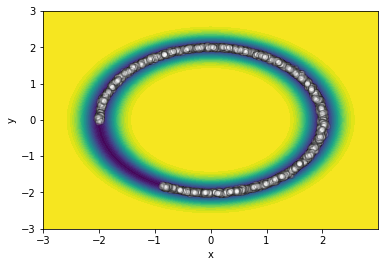

In [3]:
#you can run the simulation farther by running this
for round in range(250):
    trj1 = my_sim.run_noPlt(newPoints, nstepmax = 5)
    trj1 = my_sim.PreAll(trj1)
    
    com_trjs = []

    for theta in range(len(trj1)):
        com_trjs.append(np.concatenate((trjs[theta], trj1[theta])))
    
    trjs = np.array(com_trjs)
    trjs_theta = np.array(my_sim.map(trjs))
    
    #updates the std and mean
    #note that the standard deviation and mean are stored in the my_sim object while we're keeping
    #track of the full trajectories so far in trjs and trjs_theta
    my_sim.updateStat(trjs_theta) # based on all trajectories
    
    
    #find states in least count clusters, and also which clusters points belonged to
    trjs_Sp,cl_trjs,cl_centroids,cl_counts = my_sim.PreSamp(trjs, starting_n = N)
    
    #this should be a numpy array with K rows, the ith row is an array 
    #of theta_i evaluated at each data point in trjs_Sp
    trjs_Sp_theta = np.array(my_sim.map(trjs_Sp))
    #print(trjs_Sp_theta)
    
    
    W_1 = my_sim.updateW(trjs,cl_trjs,cl_centroids,cl_counts, W_0)
    W_0 = W_1
    Ws.append(W_0)
    
    #this will plot the least count clusters
    """
    x = trjs_Sp[0]
    y = trjs_Sp[1]
    plt.plot(x,y, 'o')
    plt.xlim([-3,3])
    plt.ylim([-3,3])
    plt.show()
    """
    #find points to start sampling from for next round
    newPoints = my_sim.findStarting(trjs_Sp_theta, trjs_Sp, W_1, starting_n = N )
    
#print(Ws)
my_sim.pltFinalPoints(trjs_theta)


In [4]:
#percentage of the circle explored
my_sim.percentage_explored(trjs_theta[D,:])

0.84


0.84

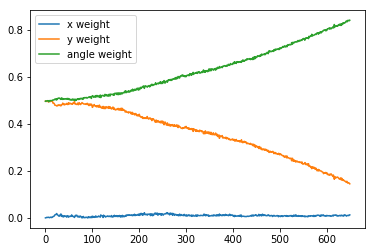

In [5]:
W_array = np.array(Ws)

plt.plot(range(len(Ws)),W_array[:,0],label='x weight')
plt.plot(range(len(Ws)),W_array[:,1],label='y weight')
#plt.plot(range(len(Ws)),W_array[:,2],label='y weight')

plt.plot(range(len(Ws)),W_array[:,D],label='angle weight')

plt.legend()
#plt.savefig('typicalTSbetterclusteringweightsgraph',dpi=500)
plt.show()
#np.save('TSbetterclusteringweights', W_array)


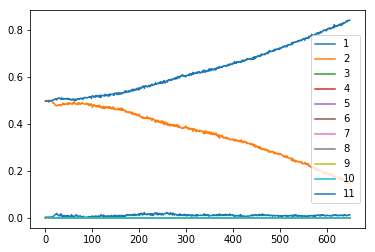

In [6]:
import numpy as np

#W_array = np.array(Ws)
#print(W_array)
for i in range(n_OP):
    plt.plot(range(len(Ws)),W_array[:,i],label=i+1)
    
plt.legend()
plt.show()